# 1. Set up the notebook

Import modules.

In [1]:
import numpy as np
import sympy as sym
import json
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.interpolate import interp1d
from IPython.display import display, IFrame, HTML

Define a function to load data from a hardware flight test and resample it at 100 Hz using linear interpolation.

In [2]:
def load_hardware_data(filename, t_min_offset=0, t_max_offset=0, only_in_flight=False):
    # load raw data
    with open(filename, 'r') as f:
        data = json.load(f)

    # convert lists to numpy arrays
    for val in data.values():
        for key in val.keys():
            val[key] = np.array(val[key])

    # create an array of times at which to subsample
    t_min = -np.inf
    t_max = np.inf
    for key, val in data.items():
        t_min = max(t_min, val['time'][0])
        t_max = min(t_max, val['time'][-1])
    t_min += t_min_offset * 1000
    t_max -= t_max_offset * 1000
    nt = int(1 + np.floor((t_max - t_min) / 10.))
    t = np.arange(0, 10 * nt, 10) / 1000.
    resampled_data = {'time': t}

    # resample raw data with linear interpolation
    for k, v in data.items():
        f = interp1d((v['time'] - t_min) / 1000., v['data'])
        resampled_data[k] = f(t)
    
    # truncate to times when o_z_des is positive
    if only_in_flight:
        i = []
        for k in ['ae483log.o_z_des', 'ctrltarget.z']:
            if k in resampled_data.keys():
                j = np.argwhere(resampled_data[k] > 0).flatten()
                if len(j) > len(i):
                    i = j
        if len(i) < 2:
            raise Exception(
                'Failed to get "only_in_flight" data.\n' + \
                ' - Did you remember to log "ae483log.o_z_des" and was it ever positive?\n' + \
                ' - Did you remember to log "ctrltarget.z" and was it ever positive?\n'
            )
        for key in resampled_data.keys():
            resampled_data[key] = resampled_data[key][i[0]:i[-1]]
        
    # return the resampled data
    return resampled_data

Define a function to compute RMSE.

In [3]:
def rmse(x, y):
    return np.sqrt(np.mean((x - y)**2))

Define the rotation matrix $R_1^0$ as a function of the yaw angle $\psi$, the pitch angle $\theta$, and the roll angle $\phi$.

In [4]:
# Define symbolic variables
psi, theta, phi = sym.symbols('psi, theta, phi')

# Define rotation about the body-fixed z axis by psi
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0],
                 [sym.sin(psi), sym.cos(psi), 0],
                 [0, 0, 1]])

# Define rotation about the body-fixed y axis by theta
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)],
                 [0, 1, 0],
                 [-sym.sin(theta), 0, sym.cos(theta)]])

# Define rotation about the body-fixed x axis by phi
Rx = sym.Matrix([[1, 0, 0],
                 [0, sym.cos(phi), -sym.sin(phi)],
                 [0, sym.sin(phi), sym.cos(phi)]])

# Apply sequential transformation to compute the rotation
# matrix R_1in0 that describes the orientation of the drone
# (i.e., of frame 1 in the coordinates of frame 0)
R_1in0 = Rz @ Ry @ Rx

# Create a function that returns R_1in0 as a numpy array
R_1in0 = sym.lambdify((psi, theta, phi), R_1in0)

# Delete variables that are no longer needed
del psi, theta, phi, Rz, Ry, Rx

# 2. Flight tests to debug observer implementation

## 2.1 Hover test using the old observer code

**FIXME: REPLACE THIS CELL WITH THE USUAL DESCRIPTION AND VIDEO OF FLIGHT TEST.**

Load and parse data.

In [59]:
# flight test data
data = load_hardware_data('cc_co_hover_old_2.json', only_in_flight=False)

# time
t = data['time']

# state estimates from custom observer
o_x_custom = data['ae483log.o_x']
o_y_custom = data['ae483log.o_y']
o_z_custom = data['ae483log.o_z']
psi_custom = data['ae483log.psi']
theta_custom = data['ae483log.theta']
phi_custom = data['ae483log.phi']
v_x_custom = data['ae483log.v_x']
v_y_custom = data['ae483log.v_y']
v_z_custom = data['ae483log.v_z']

# state estimates from default observer
o_x_default = data['stateEstimate.x']
o_y_default = data['stateEstimate.y']
o_z_default = data['stateEstimate.z']
psi_default = np.deg2rad(data['stateEstimate.yaw'])
theta_default = - np.deg2rad(data['stateEstimate.pitch'])
phi_default = np.deg2rad(data['stateEstimate.roll'])
v_x_in0_default = data['stateEstimate.vx']
v_y_in0_default = data['stateEstimate.vy']
v_z_in0_default = data['stateEstimate.vz']

# desired position
o_x_des = data['ae483log.o_x_des']
o_y_des = data['ae483log.o_y_des']
o_z_des = data['ae483log.o_z_des']

Convert the estimates of linear velocity that come from the default observer from the world frame (i.e., frame 0) to the body frame (i.e., frame 1) by applying the following coordinate transformation at each time step:

$$v_{0, 1}^1 = \left(R_1^0\right)^T v_{0, 1}^0.$$

This is necessary in order to compare the estimates of linear velocity that come from the default observer to the estimates of linear velocity that come from your custom observer.

In [60]:
# Create empty numpy arrays to hold the results
v_x_default = np.empty_like(v_x_in0_default)
v_y_default = np.empty_like(v_y_in0_default)
v_z_default = np.empty_like(v_z_in0_default)

# Apply coordinate transformation at each time step
for i in range(0, len(t)):
    # Get v in frame 0 at i'th time step from its components
    v_in0 = np.array([
        v_x_in0_default[i],
        v_y_in0_default[i],
        v_z_in0_default[i],
    ])
    
    # Get v in frame 1 at i'th time step by coordinate transformation
    v_in1 = R_1in0(psi_default[i], theta_default[i], psi_default[i]).T @ v_in0
    
    # Get components of v in frame 1 at i'th time step
    v_x_default[i] = v_in1[0]
    v_y_default[i] = v_in1[1]
    v_z_default[i] = v_in1[2]

Apply offline implementation of custom observer.

**FIXME: If the observer you are implementing offline (here) is different from the observer you implemented online (in firmware, to produce this flight test), then replace this cell with a description of what you changed (e.g., weights) and why.**

In [61]:
# Define constants
g = 9.81
k_flow = 4.09255568
o_x_eq = 0.
o_y_eq = 0.
o_z_eq = 0.5 # <-- FIXME: change equilibrium height
anchors_x = [-1.82, -3.57, 1.82, 2.67, -3.61, 1.84, 2.74, -1.85]
anchors_y = [2.18, 3.18, 2.21, -3.30, -3.30, -0.90, 3.18, -0.93]
anchors_z = [1.10, 2.24, 1.10, 2.20, 2.25, 1.10, 2.24, 1.09]
x0 = anchors_x[0]
x1 = anchors_x[1]
x2 = anchors_x[2]
x3 = anchors_x[3]
x4 = anchors_x[4]
x5 = anchors_x[5]
x6 = anchors_x[6]
x7 = anchors_x[7]
y0 = anchors_y[0]
y1 = anchors_y[1]
y2 = anchors_y[2]
y3 = anchors_y[3]
y4 = anchors_y[4]
y5 = anchors_y[5]
y6 = anchors_y[6]
y7 = anchors_y[7]
z0 = anchors_z[0]
z1 = anchors_z[1]
z2 = anchors_z[2]
z3 = anchors_z[3]
z4 = anchors_z[4]
z5 = anchors_z[5]
z6 = anchors_z[6]
z7 = anchors_z[7]
dt = 0.01

# Get inputs
w_x_offline = data['ae483log.w_x']
w_y_offline = data['ae483log.w_y']
w_z_offline = data['ae483log.w_z']
a_z_offline = data['ae483log.a_z']

# Get outputs
n_x_offline = data['ae483log.n_x']
n_y_offline = data['ae483log.n_y']
r_offline = data['ae483log.r']
d0_offline = data['ae483log.d0']
d1_offline = data['ae483log.d1']
d2_offline = data['ae483log.d2']
d3_offline = data['ae483log.d3']
d4_offline = data['ae483log.d4']
d5_offline = data['ae483log.d5']
d6_offline = data['ae483log.d6']
d7_offline = data['ae483log.d7']

# Initialize estimates
o_x = 0.
o_y = 0.
o_z = 0.
psi = 0.
theta = 0.
phi = 0.
v_x = 0.
v_y = 0.
v_z = 0.

# Initialize storage (do not change)
o_x_offline = np.zeros(len(t))
o_y_offline = np.zeros(len(t))
o_z_offline = np.zeros(len(t))
psi_offline = np.zeros(len(t))
theta_offline = np.zeros(len(t))
phi_offline = np.zeros(len(t))
v_x_offline = np.zeros(len(t))
v_y_offline = np.zeros(len(t))
v_z_offline = np.zeros(len(t))

# Iterate over all time steps
for i in range(len(t)):
    # Get measurements (do not change)
    w_x = w_x_offline[i]
    w_y = w_y_offline[i]
    w_z = w_z_offline[i]
    a_z = a_z_offline[i]
    n_x = n_x_offline[i]
    n_y = n_y_offline[i]
    r = r_offline[i]
    d0 = d0_offline[i]
    d1 = d1_offline[i]
    d2 = d2_offline[i]
    d3 = d3_offline[i]
    d4 = d4_offline[i]
    d5 = d5_offline[i]
    d6 = d6_offline[i]
    d7 = d7_offline[i]
    

    # Compute each element of:
    #
    #  C x + D u - y
    #
    Y_0 = (o_x*(o_x_eq - x0))/np.sqrt((o_x_eq - x0)*(o_x_eq - x0) + (o_y_eq - y0)*(o_y_eq - y0) + (o_z_eq - z0)*(o_z_eq - z0)) + (o_y*(o_y_eq - y0))/np.sqrt((o_x_eq - x0)*(o_x_eq - x0) + (o_y_eq - y0)*(o_y_eq - y0) + (o_z_eq - z0)*(o_z_eq - z0)) + (o_z*(o_z_eq - z0))/np.sqrt((o_x_eq - x0)*(o_x_eq - x0) + (o_y_eq - y0)*(o_y_eq - y0) + (o_z_eq - z0)*(o_z_eq - z0)) - d0 + np.sqrt((o_x_eq - x0)*(o_x_eq - x0) + (o_y_eq -  y0)*(o_y_eq - y0) + (o_z_eq - z0)*(o_z_eq - z0))
    Y_1 = (o_x*(o_x_eq - x1))/np.sqrt((o_x_eq - x1)*(o_x_eq - x1) + (o_y_eq - y1)*(o_y_eq - y1) + (o_z_eq - z1)*(o_z_eq - z1)) + (o_y*(o_y_eq - y1))/np.sqrt((o_x_eq - x1)*(o_x_eq - x1) + (o_y_eq - y1)*(o_y_eq - y1) + (o_z_eq - z1)*(o_z_eq - z1)) + (o_z*(o_z_eq - z1))/np.sqrt((o_x_eq - x1)*(o_x_eq - x1) + (o_y_eq - y1)*(o_y_eq - y1) + (o_z_eq - z1)*(o_z_eq - z1)) - d1 + np.sqrt((o_x_eq - x1)*(o_x_eq - x1) + (o_y_eq -  y1)*(o_y_eq - y1) + (o_z_eq - z1)*(o_z_eq - z1))
    Y_2 = (o_x*(o_x_eq - x2))/np.sqrt((o_x_eq - x2)*(o_x_eq - x2) + (o_y_eq - y2)*(o_y_eq - y2) + (o_z_eq - z2)*(o_z_eq - z2)) + (o_y*(o_y_eq - y2))/np.sqrt((o_x_eq - x2)*(o_x_eq - x2) + (o_y_eq - y2)*(o_y_eq - y2) + (o_z_eq - z2)*(o_z_eq - z2)) + (o_z*(o_z_eq - z2))/np.sqrt((o_x_eq - x2)*(o_x_eq - x2) + (o_y_eq - y2)*(o_y_eq - y2) + (o_z_eq - z2)*(o_z_eq - z2)) - d2 + np.sqrt((o_x_eq - x2)*(o_x_eq - x2) + (o_y_eq -  y2)*(o_y_eq - y2) + (o_z_eq - z2)*(o_z_eq - z2))
    Y_3 = (o_x*(o_x_eq - x3))/np.sqrt((o_x_eq - x3)*(o_x_eq - x3) + (o_y_eq - y3)*(o_y_eq - y3) + (o_z_eq - z3)*(o_z_eq - z3)) + (o_y*(o_y_eq - y3))/np.sqrt((o_x_eq - x3)*(o_x_eq - x3) + (o_y_eq - y3)*(o_y_eq - y3) + (o_z_eq - z3)*(o_z_eq - z3)) + (o_z*(o_z_eq - z3))/np.sqrt((o_x_eq - x3)*(o_x_eq - x3) + (o_y_eq - y3)*(o_y_eq - y3) + (o_z_eq - z3)*(o_z_eq - z3)) - d3 + np.sqrt((o_x_eq - x3)*(o_x_eq - x3) + (o_y_eq -  y3)*(o_y_eq - y3) + (o_z_eq - z3)*(o_z_eq - z3))
    Y_4 = (o_x*(o_x_eq - x4))/np.sqrt((o_x_eq - x4)*(o_x_eq - x4) + (o_y_eq - y4)*(o_y_eq - y4) + (o_z_eq - z4)*(o_z_eq - z4)) + (o_y*(o_y_eq - y4))/np.sqrt((o_x_eq - x4)*(o_x_eq - x4) + (o_y_eq - y4)*(o_y_eq - y4) + (o_z_eq - z4)*(o_z_eq - z4)) + (o_z*(o_z_eq - z4))/np.sqrt((o_x_eq - x4)*(o_x_eq - x4) + (o_y_eq - y4)*(o_y_eq - y4) + (o_z_eq - z4)*(o_z_eq - z4)) - d4 + np.sqrt((o_x_eq - x4)*(o_x_eq - x4) + (o_y_eq -  y4)*(o_y_eq - y4) + (o_z_eq - z4)*(o_z_eq - z4))
    Y_5 = (o_x*(o_x_eq - x5))/np.sqrt((o_x_eq - x5)*(o_x_eq - x5) + (o_y_eq - y5)*(o_y_eq - y5) + (o_z_eq - z5)*(o_z_eq - z5)) + (o_y*(o_y_eq - y5))/np.sqrt((o_x_eq - x5)*(o_x_eq - x5) + (o_y_eq - y5)*(o_y_eq - y5) + (o_z_eq - z5)*(o_z_eq - z5)) + (o_z*(o_z_eq - z5))/np.sqrt((o_x_eq - x5)*(o_x_eq - x5) + (o_y_eq - y5)*(o_y_eq - y5) + (o_z_eq - z5)*(o_z_eq - z5)) - d5 + np.sqrt((o_x_eq - x5)*(o_x_eq - x5) + (o_y_eq -  y5)*(o_y_eq - y5) + (o_z_eq - z5)*(o_z_eq - z5))
    Y_6 = (o_x*(o_x_eq - x6))/np.sqrt((o_x_eq - x6)*(o_x_eq - x6) + (o_y_eq - y6)*(o_y_eq - y6) + (o_z_eq - z6)*(o_z_eq - z6)) + (o_y*(o_y_eq - y6))/np.sqrt((o_x_eq - x6)*(o_x_eq - x6) + (o_y_eq - y6)*(o_y_eq - y6) + (o_z_eq - z6)*(o_z_eq - z6)) + (o_z*(o_z_eq - z6))/np.sqrt((o_x_eq - x6)*(o_x_eq - x6) + (o_y_eq - y6)*(o_y_eq - y6) + (o_z_eq - z6)*(o_z_eq - z6)) - d6 + np.sqrt((o_x_eq - x6)*(o_x_eq - x6) + (o_y_eq -  y6)*(o_y_eq - y6) + (o_z_eq - z6)*(o_z_eq - z6))
    Y_7 = (o_x*(o_x_eq - x7))/np.sqrt((o_x_eq - x7)*(o_x_eq - x7) + (o_y_eq - y7)*(o_y_eq - y7) + (o_z_eq - z7)*(o_z_eq - z7)) + (o_y*(o_y_eq - y7))/np.sqrt((o_x_eq - x7)*(o_x_eq - x7) + (o_y_eq - y7)*(o_y_eq - y7) + (o_z_eq - z7)*(o_z_eq - z7)) + (o_z*(o_z_eq - z7))/np.sqrt((o_x_eq - x7)*(o_x_eq - x7) + (o_y_eq - y7)*(o_y_eq - y7) + (o_z_eq - z7)*(o_z_eq - z7)) - d7 + np.sqrt((o_x_eq - x7)*(o_x_eq - x7) + (o_y_eq -  y7)*(o_y_eq - y7) + (o_z_eq - z7)*(o_z_eq - z7))
    Y_8 = -k_flow * w_y +(k_flow * v_x)/o_z_eq - n_x
    Y_9 = k_flow * w_x +(k_flow * v_y)/o_z_eq - n_y
    Y_10 = o_z - r
    
    # Update estimates
    o_x += dt*(-0.321942986156017*Y_0 - 0.360091197357167*Y_1 - 0.00693842240377889*Y_10 + 0.318365190026611*Y_2 + 0.299903852114275*Y_3 - 0.355665807343492*Y_4 + 0.442238005738499*Y_5 + 0.308597523816907*Y_6 - 0.440053855994591*Y_7 - 0.0715583737537656*Y_8 + 5.12544989507709e-5*Y_9 + v_x)
    o_y += dt*(0.421591401397973*Y_0 + 0.350885943671384*Y_1 + 0.0269048563831952*Y_10 + 0.423130343013224*Y_2 - 0.405422944003029*Y_3 - 0.355951808659831*Y_4 - 0.237318519656177*Y_5 + 0.391808269171014*Y_6 - 0.24175981326639*Y_7 + 5.17861682512524e-5*Y_8 - 0.0782767553493582*Y_9 + v_y)
    o_z += dt*(0.00978650662019886*Y_0 + 0.0166062866884265*Y_1 - 2.28018924263333*Y_10 + 0.00989397450977831*Y_2 + 0.0190825845349324*Y_3 + 0.0170945088575677*Y_4 + 0.0144196994197055*Y_5 + 0.0188045399251483*Y_6 + 0.0138106476337786*Y_7 - 1.11146555882439e-5*Y_8 + 4.07175659351284e-5*Y_9 + v_z)
    psi += dt * w_z
    theta += dt*(0.000743649050884714*Y_0 + 0.000832082214889116*Y_1 + 4.21524245183295e-6*Y_10 - 0.000737276508755911*Y_2 - 0.000692565690368467*Y_3 + 0.000823526337380634*Y_4 - 0.00102218290302062*Y_5 - 0.000714565289197534*Y_6 + 0.00101841351514599*Y_7 + 0.01645100613059*Y_8 - 1.21828073969702e-7*Y_9 + w_y)
    phi += dt*(0.0011102988440636*Y_0 + 0.000924017496367406*Y_1 + 1.32718313490127e-5*Y_10 + 0.00111634434284999*Y_2 - 0.00106702791703278*Y_3 - 0.000938737703011303*Y_4 - 0.00062368612223573*Y_5 + 0.00103399380969206*Y_6 - 0.000638144033820692*Y_7 + 1.3183332132583e-7*Y_8 - 0.0206557025088524*Y_9 + w_x)
    v_x += dt*(-0.0157809532951908*Y_0 - 0.0176554807788392*Y_1 - 0.000178319846793862*Y_10 + 0.0156333237437844*Y_2 + 0.0146982091913017*Y_3 - 0.0174629114240703*Y_4 + 0.021687439905286*Y_5 + 0.015152395274315*Y_6 - 0.0215988910728946*Y_7 - 0.269089559817413*Y_8 + 2.79600027359229e-6*Y_9 + g*theta)
    v_y += dt*(0.0217049934206139*Y_0 + 0.0180637216418776*Y_1 + 0.000686014553786233*Y_10 + 0.0218100340380711*Y_2 - 0.020864233505667*Y_3 - 0.0183430854593641*Y_4 - 0.0122013771782201*Y_5 + 0.0201990669214066*Y_6 - 0.0124657913716817*Y_7 + 2.93619610321487e-6*Y_8 - 0.29435501592153*Y_9 - g*phi)
    v_z += dt*(0.0112727231781869*Y_0 + 0.0189425160283223*Y_1 - 2.57345089101819*Y_10 + 0.0113181546686818*Y_2 + 0.0213193506325072*Y_3 + 0.0191761230779908*Y_4 + 0.0161150786052919*Y_5 + 0.0213619095276965*Y_6 + 0.0155311781876625*Y_7 - 1.41496323216679e-5*Y_8 + 5.26120758410498e-5*Y_9 + a_z - g)

    # Store estimates (do not change)
    o_x_offline[i] = o_x
    o_y_offline[i] = o_y
    o_z_offline[i] = o_z
    psi_offline[i] = psi
    theta_offline[i] = theta
    phi_offline[i] = phi
    v_x_offline[i] = v_x
    v_y_offline[i] = v_y
    v_z_offline[i] = v_z

Compare state estimates from default and custom observers.

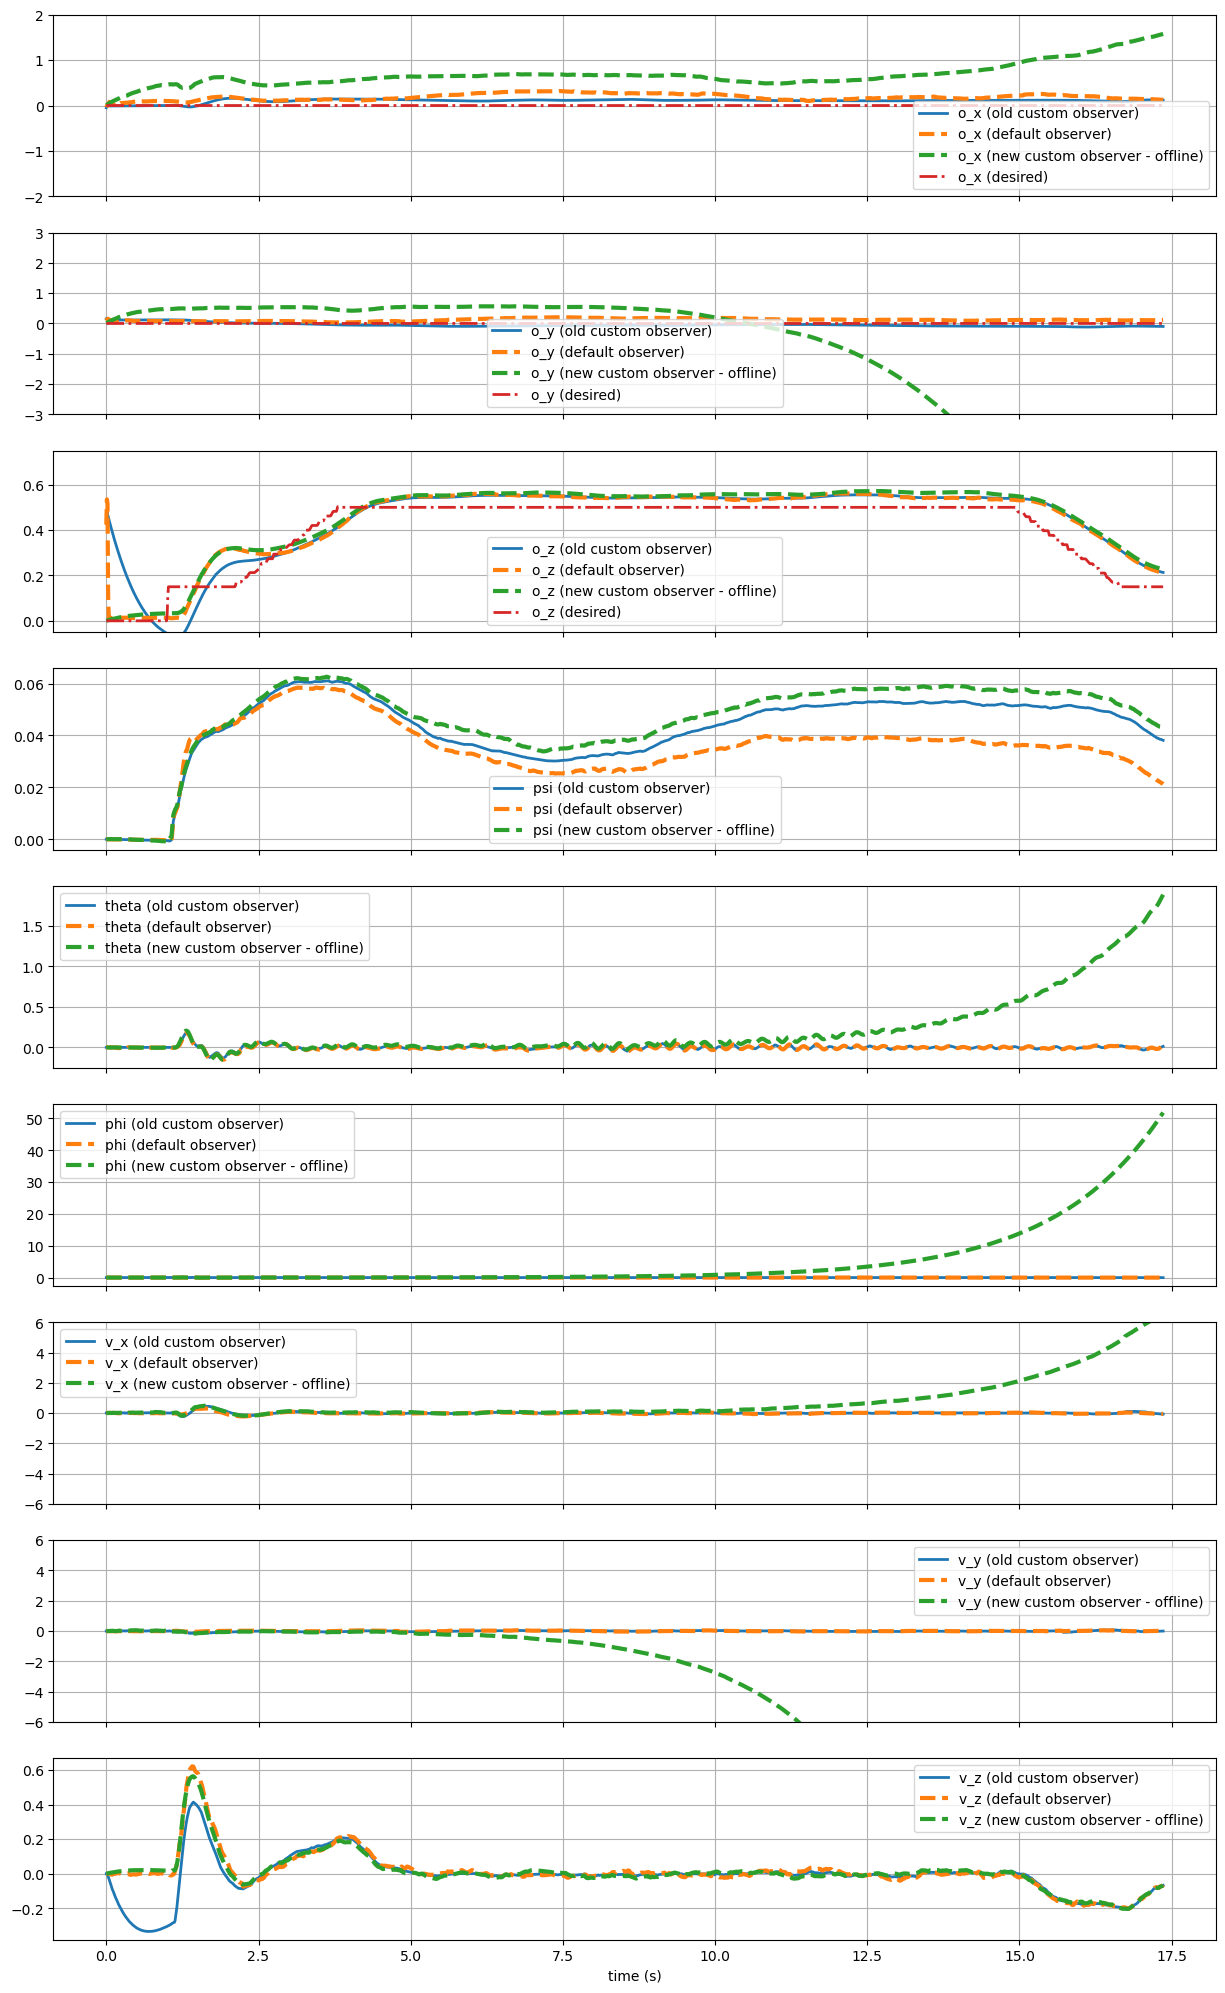

In [62]:
def comparison_plot(t, s_custom, s_default, s_offline, name, ax, s_des=None):
    ax.plot(t, s_custom, label=f'{name} (old custom observer)', linewidth=2)
    ax.plot(t, s_default, '--', label=f'{name} (default observer)', linewidth=3)
    ax.plot(t, s_offline, '--', label=f'{name} (new custom observer - offline)', linewidth=3)
    if s_des is not None:
        ax.plot(t, s_des, '-.', label=f'{name} (desired)', linewidth=2)
    ax.legend()
    ax.grid()

fig, (ax_o_x,
      ax_o_y,
      ax_o_z,
      ax_psi,
      ax_theta,
      ax_phi,
      ax_v_x,
      ax_v_y,
      ax_v_z) = plt.subplots(9, 1, figsize=(15, 25), sharex=True)

comparison_plot(t, o_x_custom, o_x_default, o_x_offline, 'o_x', ax_o_x, s_des=o_x_des)
comparison_plot(t, o_y_custom, o_y_default, o_y_offline, 'o_y', ax_o_y, s_des=o_y_des)
comparison_plot(t, o_z_custom, o_z_default, o_z_offline, 'o_z', ax_o_z, s_des=o_z_des)
comparison_plot(t, psi_custom, psi_default, psi_offline, 'psi', ax_psi)
comparison_plot(t, theta_custom, theta_default, theta_offline, 'theta', ax_theta)
comparison_plot(t, phi_custom, phi_default, phi_offline, 'phi', ax_phi)
comparison_plot(t, v_x_custom, v_x_default, v_x_offline, 'v_x', ax_v_x)
comparison_plot(t, v_y_custom, v_y_default, v_y_offline, 'v_y', ax_v_y)
comparison_plot(t, v_z_custom, v_z_default, v_z_offline, 'v_z', ax_v_z)
ax_v_z.set_xlabel('time (s)')

ax_o_x.set_ylim([-2, 2])
ax_o_y.set_ylim([-3, 3])
ax_o_z.set_ylim([-0.05, 0.75])
# ax_psi.set_ylim([-0.1, 0.1])
# ax_theta.set_ylim([-0.25, 0.25])
# ax_phi.set_ylim([-0.25, 0.25])
ax_v_x.set_ylim([-6, 6])
ax_v_y.set_ylim([-6, 6])
# ax_v_z.set_ylim([-0.5, 0.5])
plt.show()

## 2.1 GUI-Generated flight test using the old observer code

In [39]:
# flight test data
data = load_hardware_data('first_test_square_pattern.json', only_in_flight=False)

# time
t = data['time']

# state estimates from custom observer
o_x_custom = data['ae483log.o_x']
o_y_custom = data['ae483log.o_y']
o_z_custom = data['ae483log.o_z']
psi_custom = data['ae483log.psi']
theta_custom = data['ae483log.theta']
phi_custom = data['ae483log.phi']
v_x_custom = data['ae483log.v_x']
v_y_custom = data['ae483log.v_y']
v_z_custom = data['ae483log.v_z']

# state estimates from default observer
o_x_default = data['stateEstimate.x']
o_y_default = data['stateEstimate.y']
o_z_default = data['stateEstimate.z']
psi_default = np.deg2rad(data['stateEstimate.yaw'])
theta_default = - np.deg2rad(data['stateEstimate.pitch'])
phi_default = np.deg2rad(data['stateEstimate.roll'])
v_x_in0_default = data['stateEstimate.vx']
v_y_in0_default = data['stateEstimate.vy']
v_z_in0_default = data['stateEstimate.vz']

# desired position
o_x_des = data['ae483log.o_x_des']
o_y_des = data['ae483log.o_y_des']
o_z_des = data['ae483log.o_z_des']

Convert the estimates of linear velocity that come from the default observer from the world frame (i.e., frame 0) to the body frame (i.e., frame 1) by applying the following coordinate transformation at each time step:

$$v_{0, 1}^1 = \left(R_1^0\right)^T v_{0, 1}^0.$$

This is necessary in order to compare the estimates of linear velocity that come from the default observer to the estimates of linear velocity that come from your custom observer.

In [40]:
# Create empty numpy arrays to hold the results
v_x_default = np.empty_like(v_x_in0_default)
v_y_default = np.empty_like(v_y_in0_default)
v_z_default = np.empty_like(v_z_in0_default)

# Apply coordinate transformation at each time step
for i in range(0, len(t)):
    # Get v in frame 0 at i'th time step from its components
    v_in0 = np.array([
        v_x_in0_default[i],
        v_y_in0_default[i],
        v_z_in0_default[i],
    ])
    
    # Get v in frame 1 at i'th time step by coordinate transformation
    v_in1 = R_1in0(psi_default[i], theta_default[i], psi_default[i]).T @ v_in0
    
    # Get components of v in frame 1 at i'th time step
    v_x_default[i] = v_in1[0]
    v_y_default[i] = v_in1[1]
    v_z_default[i] = v_in1[2]

Apply offline implementation of custom observer.

**FIXME: If the observer you are implementing offline (here) is different from the observer you implemented online (in firmware, to produce this flight test), then replace this cell with a description of what you changed (e.g., weights) and why.**

In [43]:
# Define constants
g = 9.81
k_flow = 4.09255568
o_x_eq = 0.
o_y_eq = 0.
o_z_eq = 0.5 # <-- FIXME: change equilibrium height
anchors_x = [-1.82, -3.57, 1.82, 2.67, -3.61, 1.84, 2.74, -1.85]
anchors_y = [2.18, 3.18, 2.21, -3.30, -3.30, -0.90, 3.18, -0.93]
anchors_z = [1.10, 2.24, 1.10, 2.20, 2.25, 1.10, 2.24, 1.09]
x0 = anchors_x[0]
x1 = anchors_x[1]
x2 = anchors_x[2]
x3 = anchors_x[3]
x4 = anchors_x[4]
x5 = anchors_x[5]
x6 = anchors_x[6]
x7 = anchors_x[7]
y0 = anchors_y[0]
y1 = anchors_y[1]
y2 = anchors_y[2]
y3 = anchors_y[3]
y4 = anchors_y[4]
y5 = anchors_y[5]
y6 = anchors_y[6]
y7 = anchors_y[7]
z0 = anchors_z[0]
z1 = anchors_z[1]
z2 = anchors_z[2]
z3 = anchors_z[3]
z4 = anchors_z[4]
z5 = anchors_z[5]
z6 = anchors_z[6]
z7 = anchors_z[7]
dt = 0.01

# Get inputs
w_x_offline = data['ae483log.w_x']
w_y_offline = data['ae483log.w_y']
w_z_offline = data['ae483log.w_z']
a_z_offline = data['ae483log.a_z']

# Get outputs
n_x_offline = data['ae483log.n_x']
n_y_offline = data['ae483log.n_y']
r_offline = data['ae483log.r']
d0_offline = data['ae483log.d0']
d1_offline = data['ae483log.d1']
d2_offline = data['ae483log.d2']
d3_offline = data['ae483log.d3']
d4_offline = data['ae483log.d4']
d5_offline = data['ae483log.d5']
d6_offline = data['ae483log.d6']
d7_offline = data['ae483log.d7']

# Initialize estimates
o_x = 0.
o_y = 0.
o_z = 0.
psi = 0.
theta = 0.
phi = 0.
v_x = 0.
v_y = 0.
v_z = 0.

# Initialize storage (do not change)
o_x_offline = np.zeros(len(t))
o_y_offline = np.zeros(len(t))
o_z_offline = np.zeros(len(t))
psi_offline = np.zeros(len(t))
theta_offline = np.zeros(len(t))
phi_offline = np.zeros(len(t))
v_x_offline = np.zeros(len(t))
v_y_offline = np.zeros(len(t))
v_z_offline = np.zeros(len(t))

# Iterate over all time steps
for i in range(len(t)):
    # Get measurements (do not change)
    w_x = w_x_offline[i]
    w_y = w_y_offline[i]
    w_z = w_z_offline[i]
    a_z = a_z_offline[i]
    n_x = n_x_offline[i]
    n_y = n_y_offline[i]
    r = r_offline[i]
    d0 = d0_offline[i]
    d1 = d1_offline[i]
    d2 = d2_offline[i]
    d3 = d3_offline[i]
    d4 = d4_offline[i]
    d5 = d5_offline[i]
    d6 = d6_offline[i]
    d7 = d7_offline[i]
    

    # Compute each element of:
    #
    #  C x + D u - y
    #
    Y_0 = (o_x*(o_x_eq - x0))/np.sqrt((o_x_eq - x0)*(o_x_eq - x0) + (o_y_eq - y0)*(o_y_eq - y0) + (o_z_eq - z0)*(o_z_eq - z0)) + (o_y*(o_y_eq - y0))/np.sqrt((o_x_eq - x0)*(o_x_eq - x0) + (o_y_eq - y0)*(o_y_eq - y0) + (o_z_eq - z0)*(o_z_eq - z0)) + (o_z*(o_z_eq - z0))/np.sqrt((o_x_eq - x0)*(o_x_eq - x0) + (o_y_eq - y0)*(o_y_eq - y0) + (o_z_eq - z0)*(o_z_eq - z0)) - d0 + np.sqrt((o_x_eq - x0)*(o_x_eq - x0) + (o_y_eq -  y0)*(o_y_eq - y0) + (o_z_eq - z0)*(o_z_eq - z0))
    Y_1 = (o_x*(o_x_eq - x1))/np.sqrt((o_x_eq - x1)*(o_x_eq - x1) + (o_y_eq - y1)*(o_y_eq - y1) + (o_z_eq - z1)*(o_z_eq - z1)) + (o_y*(o_y_eq - y1))/np.sqrt((o_x_eq - x1)*(o_x_eq - x1) + (o_y_eq - y1)*(o_y_eq - y1) + (o_z_eq - z1)*(o_z_eq - z1)) + (o_z*(o_z_eq - z1))/np.sqrt((o_x_eq - x1)*(o_x_eq - x1) + (o_y_eq - y1)*(o_y_eq - y1) + (o_z_eq - z1)*(o_z_eq - z1)) - d1 + np.sqrt((o_x_eq - x1)*(o_x_eq - x1) + (o_y_eq -  y1)*(o_y_eq - y1) + (o_z_eq - z1)*(o_z_eq - z1))
    Y_2 = (o_x*(o_x_eq - x2))/np.sqrt((o_x_eq - x2)*(o_x_eq - x2) + (o_y_eq - y2)*(o_y_eq - y2) + (o_z_eq - z2)*(o_z_eq - z2)) + (o_y*(o_y_eq - y2))/np.sqrt((o_x_eq - x2)*(o_x_eq - x2) + (o_y_eq - y2)*(o_y_eq - y2) + (o_z_eq - z2)*(o_z_eq - z2)) + (o_z*(o_z_eq - z2))/np.sqrt((o_x_eq - x2)*(o_x_eq - x2) + (o_y_eq - y2)*(o_y_eq - y2) + (o_z_eq - z2)*(o_z_eq - z2)) - d2 + np.sqrt((o_x_eq - x2)*(o_x_eq - x2) + (o_y_eq -  y2)*(o_y_eq - y2) + (o_z_eq - z2)*(o_z_eq - z2))
    Y_3 = (o_x*(o_x_eq - x3))/np.sqrt((o_x_eq - x3)*(o_x_eq - x3) + (o_y_eq - y3)*(o_y_eq - y3) + (o_z_eq - z3)*(o_z_eq - z3)) + (o_y*(o_y_eq - y3))/np.sqrt((o_x_eq - x3)*(o_x_eq - x3) + (o_y_eq - y3)*(o_y_eq - y3) + (o_z_eq - z3)*(o_z_eq - z3)) + (o_z*(o_z_eq - z3))/np.sqrt((o_x_eq - x3)*(o_x_eq - x3) + (o_y_eq - y3)*(o_y_eq - y3) + (o_z_eq - z3)*(o_z_eq - z3)) - d3 + np.sqrt((o_x_eq - x3)*(o_x_eq - x3) + (o_y_eq -  y3)*(o_y_eq - y3) + (o_z_eq - z3)*(o_z_eq - z3))
    Y_4 = (o_x*(o_x_eq - x4))/np.sqrt((o_x_eq - x4)*(o_x_eq - x4) + (o_y_eq - y4)*(o_y_eq - y4) + (o_z_eq - z4)*(o_z_eq - z4)) + (o_y*(o_y_eq - y4))/np.sqrt((o_x_eq - x4)*(o_x_eq - x4) + (o_y_eq - y4)*(o_y_eq - y4) + (o_z_eq - z4)*(o_z_eq - z4)) + (o_z*(o_z_eq - z4))/np.sqrt((o_x_eq - x4)*(o_x_eq - x4) + (o_y_eq - y4)*(o_y_eq - y4) + (o_z_eq - z4)*(o_z_eq - z4)) - d4 + np.sqrt((o_x_eq - x4)*(o_x_eq - x4) + (o_y_eq -  y4)*(o_y_eq - y4) + (o_z_eq - z4)*(o_z_eq - z4))
    Y_5 = (o_x*(o_x_eq - x5))/np.sqrt((o_x_eq - x5)*(o_x_eq - x5) + (o_y_eq - y5)*(o_y_eq - y5) + (o_z_eq - z5)*(o_z_eq - z5)) + (o_y*(o_y_eq - y5))/np.sqrt((o_x_eq - x5)*(o_x_eq - x5) + (o_y_eq - y5)*(o_y_eq - y5) + (o_z_eq - z5)*(o_z_eq - z5)) + (o_z*(o_z_eq - z5))/np.sqrt((o_x_eq - x5)*(o_x_eq - x5) + (o_y_eq - y5)*(o_y_eq - y5) + (o_z_eq - z5)*(o_z_eq - z5)) - d5 + np.sqrt((o_x_eq - x5)*(o_x_eq - x5) + (o_y_eq -  y5)*(o_y_eq - y5) + (o_z_eq - z5)*(o_z_eq - z5))
    Y_6 = (o_x*(o_x_eq - x6))/np.sqrt((o_x_eq - x6)*(o_x_eq - x6) + (o_y_eq - y6)*(o_y_eq - y6) + (o_z_eq - z6)*(o_z_eq - z6)) + (o_y*(o_y_eq - y6))/np.sqrt((o_x_eq - x6)*(o_x_eq - x6) + (o_y_eq - y6)*(o_y_eq - y6) + (o_z_eq - z6)*(o_z_eq - z6)) + (o_z*(o_z_eq - z6))/np.sqrt((o_x_eq - x6)*(o_x_eq - x6) + (o_y_eq - y6)*(o_y_eq - y6) + (o_z_eq - z6)*(o_z_eq - z6)) - d6 + np.sqrt((o_x_eq - x6)*(o_x_eq - x6) + (o_y_eq -  y6)*(o_y_eq - y6) + (o_z_eq - z6)*(o_z_eq - z6))
    Y_7 = (o_x*(o_x_eq - x7))/np.sqrt((o_x_eq - x7)*(o_x_eq - x7) + (o_y_eq - y7)*(o_y_eq - y7) + (o_z_eq - z7)*(o_z_eq - z7)) + (o_y*(o_y_eq - y7))/np.sqrt((o_x_eq - x7)*(o_x_eq - x7) + (o_y_eq - y7)*(o_y_eq - y7) + (o_z_eq - z7)*(o_z_eq - z7)) + (o_z*(o_z_eq - z7))/np.sqrt((o_x_eq - x7)*(o_x_eq - x7) + (o_y_eq - y7)*(o_y_eq - y7) + (o_z_eq - z7)*(o_z_eq - z7)) - d7 + np.sqrt((o_x_eq - x7)*(o_x_eq - x7) + (o_y_eq -  y7)*(o_y_eq - y7) + (o_z_eq - z7)*(o_z_eq - z7))
    Y_8 = -k_flow * w_y +(k_flow * v_x)/o_z_eq - n_x
    Y_9 = k_flow * w_x +(k_flow * v_y)/o_z_eq - n_y
    Y_10 = o_z - r
    
    # Update estimates
    o_x += dt*(-1.12707648705855*Y_0 - 0.5476728004585*Y_1 - 0.0339666169208879*Y_10 + 1.06158812414135*Y_2 + 0.227059392530423*Y_3 - 0.552105984522811*Y_4 + 1.66587269822643*Y_5 + 0.475526854975272*Y_6 - 2.07114365067007*Y_7 - 0.0214688706014934*Y_8 + 0.00168407966994269*Y_9 + v_x)
    o_y += dt*(1.73816242606271*Y_0 + 0.674035871250208*Y_1 + 0.0182697597468506*Y_10 + 1.69091746248964*Y_2 - 0.325418193645903*Y_3 - 0.787896464809938*Y_4 - 1.1956767991533*Y_5 + 0.657924407506712*Y_6 - 1.35219734302355*Y_7 + 0.00197779925500575*Y_8 - 0.0227901005026907*Y_9 + v_y)
    o_z += dt*(0.817938135344624*Y_0 + 0.722615443998249*Y_1 - 0.603140474287141*Y_10 + 1.35653032358065*Y_2 + 0.433584324169403*Y_3 + 1.05513109876531*Y_4 + 1.96351857478474*Y_5 + 1.06683224932403*Y_6 + 2.18412437166829*Y_7 - 0.00242935847370092*Y_8 + 0.00108821463471846*Y_9 + v_z)
    psi += dt * w_z
    theta += dt*(0.196479899076098*Y_0 + 0.0985626400158723*Y_1 + 0.0023957978163299*Y_10 - 0.194663521002678*Y_2 - 0.0361702630754423*Y_3 + 0.111154854141702*Y_4 - 0.280645442718842*Y_5 - 0.0837840794422355*Y_6 + 0.39561834630097*Y_7 + 0.0140088547394226*Y_8 - 0.000281307826385638*Y_9 + w_y)
    phi += dt*(0.222343647429708*Y_0 + 0.0864276427219888*Y_1 + 0.00102134292721344*Y_10 + 0.228875313860488*Y_2 - 0.0403926898816258*Y_3 - 0.103647461045156*Y_4 - 0.143265945724011*Y_5 + 0.0904416873504525*Y_6 - 0.183125525304195*Y_7 + 0.000269473931307429*Y_8 - 0.0119570739051243*Y_9 + w_x)
    v_x += dt*(-2.11423067055164*Y_0 - 1.04869146159933*Y_1 - 0.0389758213737117*Y_10 + 2.05301472113413*Y_2 + 0.401997716600069*Y_3 - 1.13729568738701*Y_4 + 3.05428792393369*Y_5 + 0.895894538280115*Y_6 - 4.11951818010848*Y_7 - 0.125052613322857*Y_8 + 0.00328725278584337*Y_9 + g*theta)
    v_y += dt*(2.75863977433452*Y_0 + 1.07168100610343*Y_1 + 0.0183343738731685*Y_10 + 2.78128700533508*Y_2 - 0.506458426054447*Y_3 - 1.27142574731835*Y_4 - 1.82078755172935*Y_5 + 1.09334023624671*Y_6 - 2.22226220214884*Y_7 + 0.00345208078526926*Y_8 - 0.125066972338275*Y_9 - g*phi)
    v_z += dt*(1.49180564220905*Y_0 + 1.26730376543032*Y_1 - 1.01179849124881*Y_10 + 2.25945122029615*Y_2 + 0.706484076467834*Y_3 + 1.78846439007433*Y_4 + 3.16676163008767*Y_5 + 1.78178164345588*Y_6 + 3.76752897355177*Y_7 - 0.004860102535236*Y_8 + 0.0020354212081781*Y_9 + a_z - g)

    # Store estimates (do not change)
    o_x_offline[i] = o_x
    o_y_offline[i] = o_y
    o_z_offline[i] = o_z
    psi_offline[i] = psi
    theta_offline[i] = theta
    phi_offline[i] = phi
    v_x_offline[i] = v_x
    v_y_offline[i] = v_y
    v_z_offline[i] = v_z

Compare state estimates from default and custom observers.

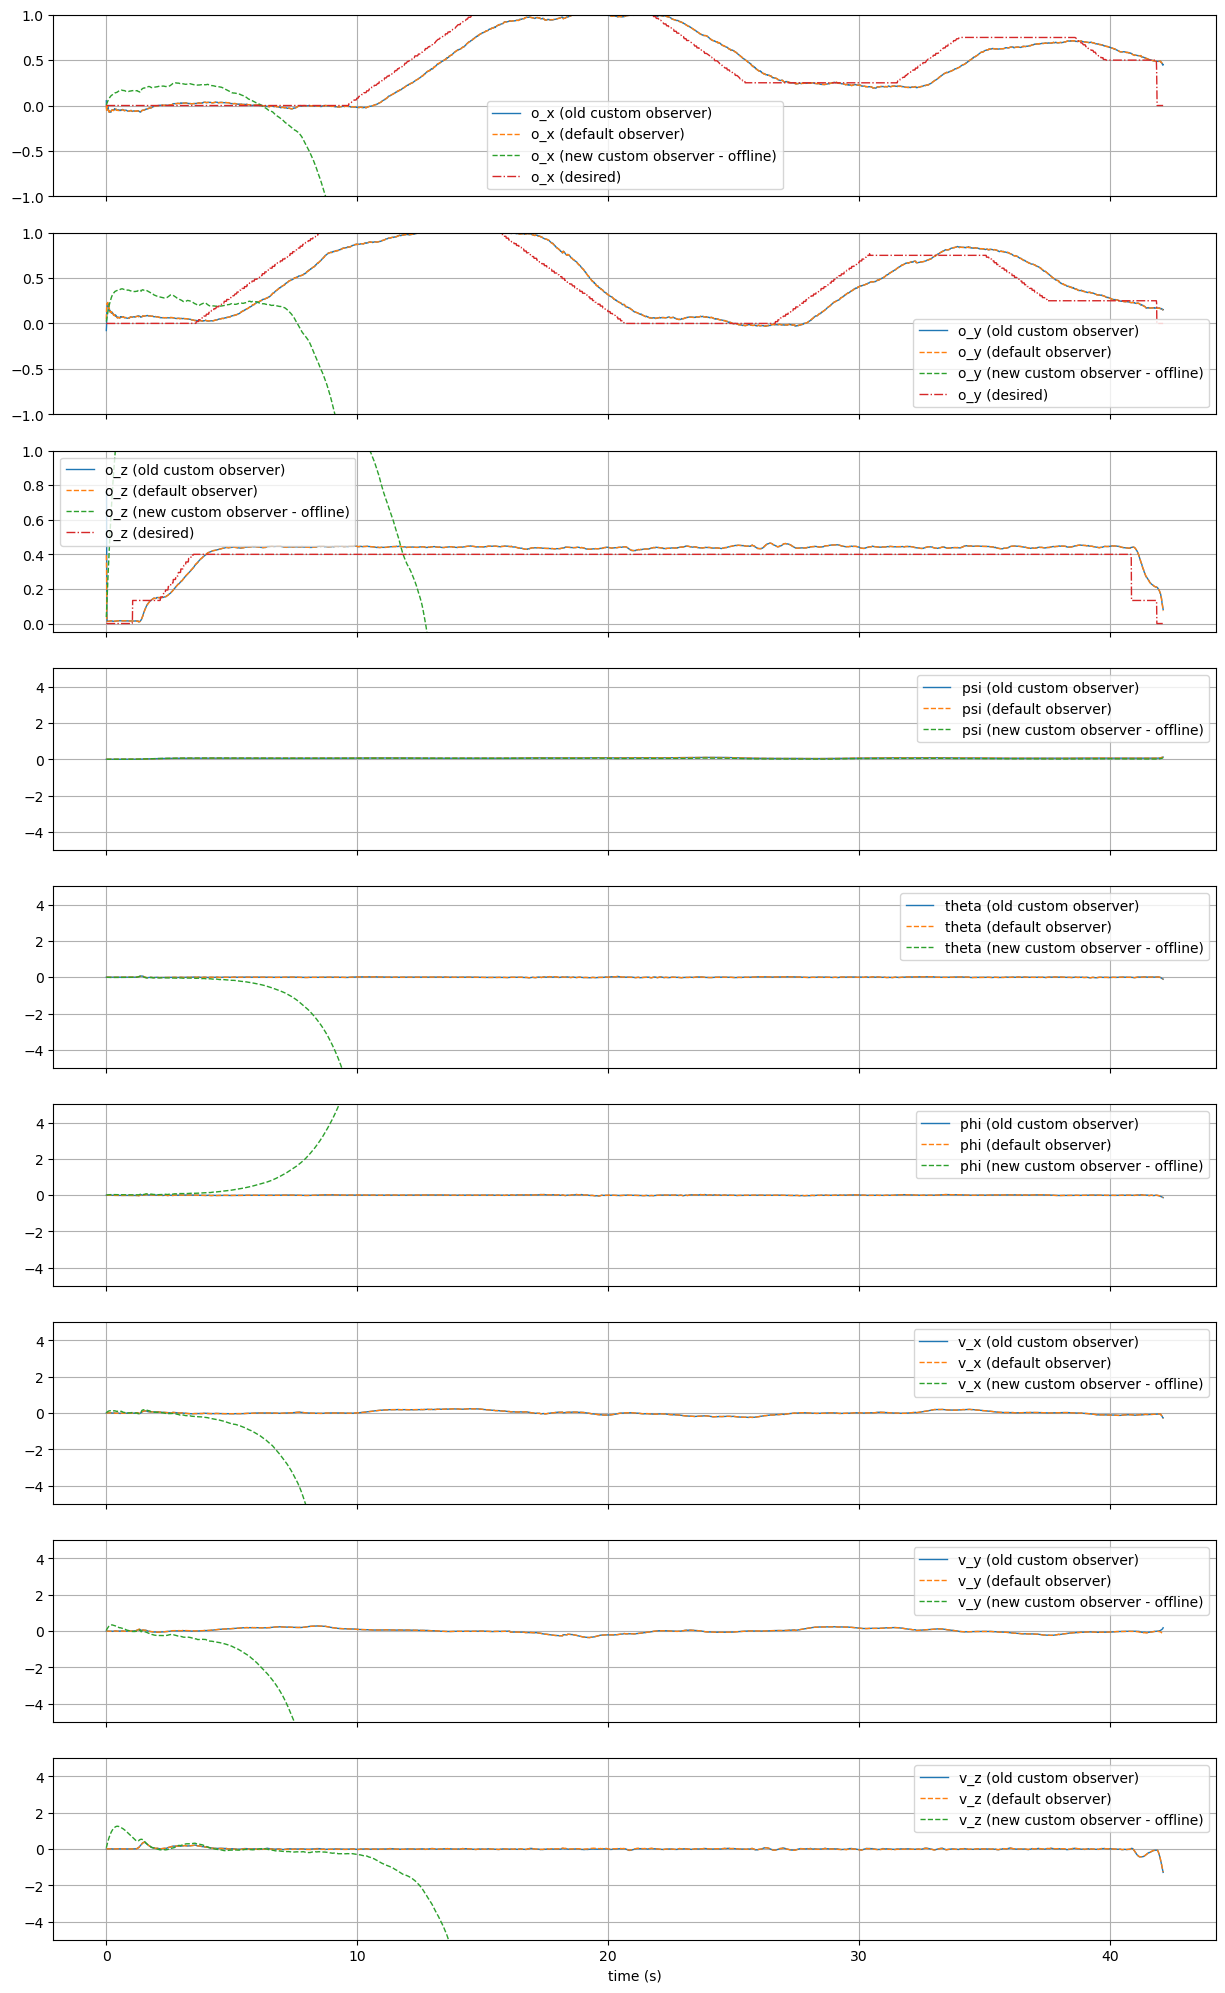

In [44]:
def comparison_plot(t, s_custom, s_default, s_offline, name, ax, s_des=None):
    ax.plot(t, s_custom, label=f'{name} (old custom observer)', linewidth=1)
    ax.plot(t, s_default, '--', label=f'{name} (default observer)', linewidth=1)
    ax.plot(t, s_offline, '--', label=f'{name} (new custom observer - offline)', linewidth=1)
    if s_des is not None:
        ax.plot(t, s_des, '-.', label=f'{name} (desired)', linewidth=1)
    ax.legend()
    ax.grid()

fig, (ax_o_x,
      ax_o_y,
      ax_o_z,
      ax_psi,
      ax_theta,
      ax_phi,
      ax_v_x,
      ax_v_y,
      ax_v_z) = plt.subplots(9, 1, figsize=(15, 25), sharex=True)

comparison_plot(t, o_x_custom, o_x_default, o_x_offline, 'o_x', ax_o_x, s_des=o_x_des)
comparison_plot(t, o_y_custom, o_y_default, o_y_offline, 'o_y', ax_o_y, s_des=o_y_des)
comparison_plot(t, o_z_custom, o_z_default, o_z_offline, 'o_z', ax_o_z, s_des=o_z_des)
comparison_plot(t, psi_custom, psi_default, psi_offline, 'psi', ax_psi)
comparison_plot(t, theta_custom, theta_default, theta_offline, 'theta', ax_theta)
comparison_plot(t, phi_custom, phi_default, phi_offline, 'phi', ax_phi)
comparison_plot(t, v_x_custom, v_x_default, v_x_offline, 'v_x', ax_v_x)
comparison_plot(t, v_y_custom, v_y_default, v_y_offline, 'v_y', ax_v_y)
comparison_plot(t, v_z_custom, v_z_default, v_z_offline, 'v_z', ax_v_z)
ax_v_z.set_xlabel('time (s)')

ax_o_x.set_ylim([-1, 1])
ax_o_y.set_ylim([-1, 1])
ax_o_z.set_ylim([-0.05, 1])
ax_psi.set_ylim([-5, 5])
ax_theta.set_ylim([-5, 5])
ax_phi.set_ylim([-5, 5])
ax_v_x.set_ylim([-5, 5])
ax_v_y.set_ylim([-5, 5])
ax_v_z.set_ylim([-5, 5])
plt.show()